In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform


    def __len__(self):
        return len(self.file_list)


    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Extract weight from file name and convert it to float
        weight = float(os.path.basename(img_path).split('_')[-1].split('.')[0])
        return image, weight

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Directories for training and testing images
train_dir = 'train'
test_dir = 'test'

In [ ]:
# Create datasets for training and testing
train_dataset = CustomDataset(
    [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.jpg')],
    transform=transform
)

test_dataset = CustomDataset(
    [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')],
    transform=transform
)

In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet152(weights="ResNet152_Weights.IMAGENET1K_V1")
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.resnet(x)

In [ ]:
model = CustomResNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
model.to(device)

Device: cuda


CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
CustomResNet (CustomResNet)                   [1, 3, 224, 224]     [1, 1]               --                   Partial
├─ResNet (resnet)                             [1, 3, 224, 224]     [1, 1]               --                   Partial
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Function to save the model and results
def save_checkpoint(epoch, model, optimizer, train_losses, val_losses, train_maes, val_maes, train_accs, val_accs):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_maes': train_maes,
        'val_maes': val_maes,
        'train_accs': train_accs,
        'val_accs': val_accs,
    }, checkpoint_path)

In [ ]:
num_epochs = 400
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_accs = []
val_accs = []

# Check if there is a checkpoint to resume from
start_epoch = 0
if os.path.exists(checkpoint_dir):
    files = os.listdir(checkpoint_dir)
    if files:
        checkpoint_path = os.path.join(checkpoint_dir, sorted(files)[-1])
        checkpoint = torch.load(checkpoint_path)
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        train_maes = checkpoint['train_maes']
        val_maes = checkpoint['val_maes']
        train_accs = checkpoint['train_accs']
        val_accs = checkpoint['val_accs']
        print(f"Resuming training from epoch {start_epoch}")

# Continue training from the loaded checkpoint
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze().float(), targets.squeeze().float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_mae += torch.mean(torch.abs(outputs.squeeze() - targets.squeeze())).item()
        correct += torch.sum(torch.abs(outputs.squeeze() - targets.squeeze()) < 3).item()
        total += targets.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_maes.append(epoch_mae)
    train_accs.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze().float(), targets.squeeze().float())
            val_loss += loss.item() * inputs.size(0)
            val_mae += torch.mean(torch.abs(outputs.squeeze() - targets.squeeze())).item()
            correct += torch.sum(torch.abs(outputs.squeeze() - targets.squeeze()) < 3).item()
            total += targets.size(0)

    val_epoch_loss = val_loss / len(test_loader.dataset)
    val_epoch_mae = val_mae / len(test_loader.dataset)
    val_epoch_acc = correct / total
    val_losses.append(val_epoch_loss)
    val_maes.append(val_epoch_mae)
    val_accs.append(val_epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {val_epoch_loss:.4f}, Train MAE: {epoch_mae:.4f}, Test MAE: {val_epoch_mae:.4f}, Train Acc: {epoch_acc:.4f}, Test Acc: {val_epoch_acc:.4f}')

    # Save model and results every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_checkpoint(epoch, model, optimizer, train_losses, val_losses, train_maes, val_maes, train_accs, val_accs)

Resuming training from epoch 400


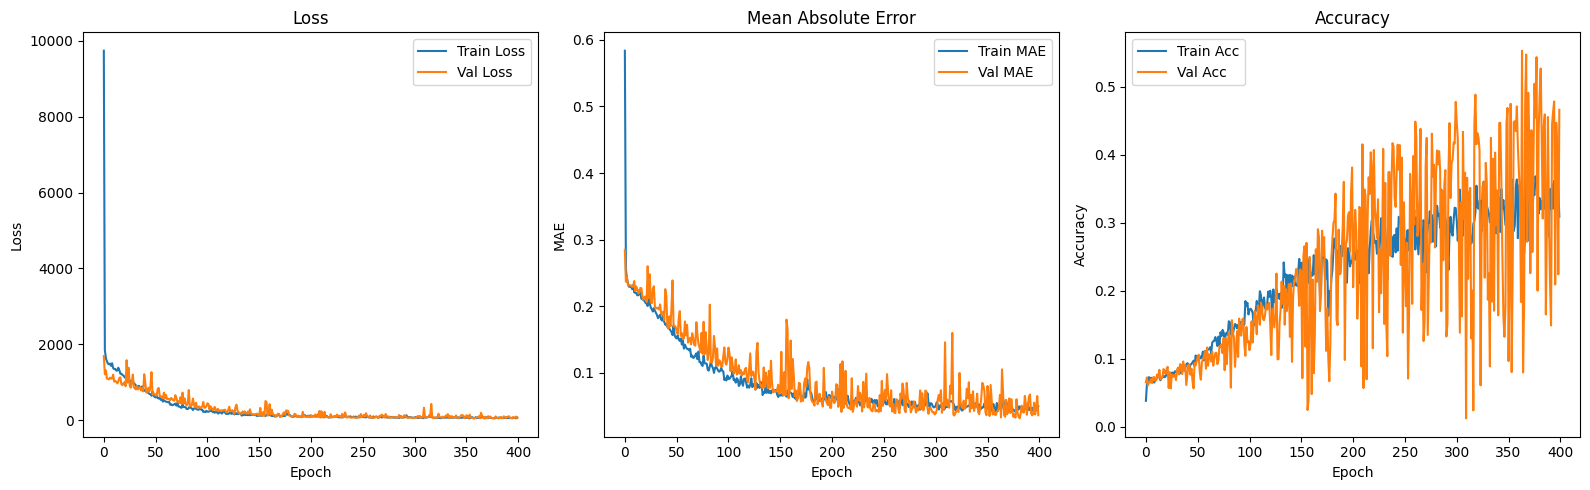

In [ ]:
# Plotting
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()